<a href="https://colab.research.google.com/github/juanmed/epipolar_geometry/blob/main/Epipolar_geometry.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install opencv-contrib-python==4.4.0.44

In [ ]:
!wget https://raw.githubusercontent.com/opencv/opencv/master/samples/data/leuvenA.jpg
!wget https://raw.githubusercontent.com/opencv/opencv/master/samples/data/leuvenB.jpg

In [27]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt

def drawlines(img1,img2,lines,pts1,pts2):
    ''' img1 - image on which we draw the epilines for the points in img2
        lines - corresponding epilines '''
    r,c = img1.shape
    img1 = cv.cvtColor(img1,cv.COLOR_GRAY2BGR)
    img2 = cv.cvtColor(img2,cv.COLOR_GRAY2BGR)
    for r,pt1,pt2 in zip(lines,pts1,pts2):
        color = tuple(np.random.randint(0,255,3).tolist())
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        img1 = cv.line(img1, (x0,y0), (x1,y1), color,1)
        img1 = cv.circle(img1,tuple(pt1),5,color,-1)
        img2 = cv.circle(img2,tuple(pt2),5,color,-1)
    return img1,img2

img1 = cv.imread("leuvenA.jpg",0)  #queryimage # left image
img2 = cv.imread("leuvenB.jpg",0) #trainimage # right image

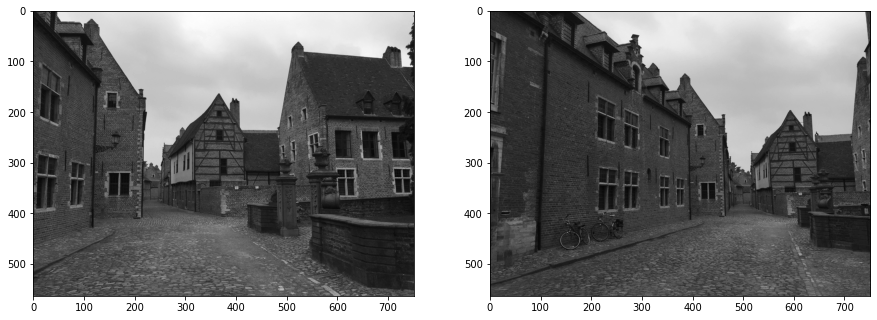

In [32]:
fig = plt.figure(figsize=(15,15))
ax1 = plt.subplot(1,2,1)
ax2 = plt.subplot(1,2,2)
ax1.imshow(img1, cmap="gray")
ax2.imshow(img2, cmap="gray")

In [28]:
sift = cv.SIFT_create()
# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)
# FLANN parameters
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)
flann = cv.FlannBasedMatcher(index_params,search_params)
matches = flann.knnMatch(des1,des2,k=2)

pts1 = []
pts2 = []
# ratio test as per Lowe's paper
for i,(m,n) in enumerate(matches):
    if m.distance < 0.8*n.distance:
        pts2.append(kp2[m.trainIdx].pt)
        pts1.append(kp1[m.queryIdx].pt)

In [29]:
pts1 = np.int32(pts1)
pts2 = np.int32(pts2)
F, mask = cv.findFundamentalMat(pts1,pts2,cv.FM_LMEDS)
# We select only inlier points
pts1 = pts1[mask.ravel()==1]
pts2 = pts2[mask.ravel()==1]

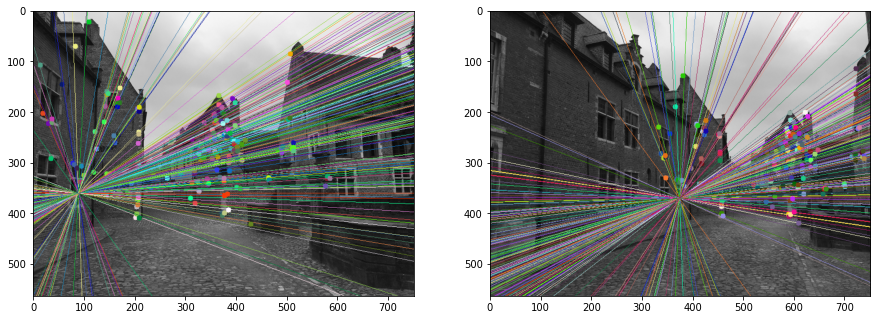

In [30]:
# Find epilines corresponding to points in right image (second image) and
# drawing its lines on left image
lines1 = cv.computeCorrespondEpilines(pts2.reshape(-1,1,2), 2,F)
lines1 = lines1.reshape(-1,3)
img5,img6 = drawlines(img1,img2,lines1,pts1,pts2)
# Find epilines corresponding to points in left image (first image) and
# drawing its lines on right image
lines2 = cv.computeCorrespondEpilines(pts1.reshape(-1,1,2), 1,F)
lines2 = lines2.reshape(-1,3)
img3,img4 = drawlines(img2,img1,lines2,pts2,pts1)

fig = plt.figure(figsize=(15,15))
ax1 = plt.subplot(1,2,1)
ax2 = plt.subplot(1,2,2)
ax1.imshow(img5)
ax2.imshow(img3)

In [39]:
# from https://github.com/opencv/opencv/blob/master/samples/data/essential_mat_data.txt
K = np.array([651.4462353114224, 0, 376.27522319223914, 0, 653.7348054191838, 280.1106539526218,0, 0, 1]).reshape(3,3)
E, mask =	cv.findEssentialMat(	pts1, pts2,K, cv.LMEDS)
pts1 = pts1[mask.ravel()==1]
pts2 = pts2[mask.ravel()==1]
_, R, t, mask =	cv.recoverPose(	E, pts1, pts2, K)

In [41]:
print("Rotation: ", R)
print("Translation:", t)

Rotation:  [[ 0.91619049  0.04155616  0.39858259]
 [-0.04686291  0.99889493  0.00357545]
 [-0.39799354 -0.02195453  0.91712548]]
Translation: [[-9.64179537e-04]
 [ 1.35824769e-01]
 [ 9.90732407e-01]]


In [2]:
T1 = np.hstack((np.identity(3),np.zeros((3,1))))
T2 = np.hstack((R,t))
homogeneous_points = cv.triangulatePoints(	T1, T2, pts1.T, pts2.T	)

NameError: ignored

In [1]:
homogeneous_points = homogeneous_points.T
homogeneous_points.shape



NameError: ignored